#  Дообучения модели на псевдоразметке

## Кое-какая теория

__Классификация с учителем на основе нейронных сетей__ — это мощный и гибкий подход, особенно если данные большие и имеют сложную структуру (например, тексты, изображения или временные ряды). Вот обзор основных реализаций нейросетевых классификаторов, их типов и особенностей:

🧠 _1. Простая полносвязная нейронная сеть (MLP — Multi-Layer Perceptron)_  
Где применимо: числовые признаки, табличные данные, базовая текстовая классификация после векторизации (TF-IDF, word2vec).  
Особенности:  
Работает как классические классификаторы, но мощнее при большом количестве признаков.  
Плохо масштабируется на длинные тексты и последовательности без специальной архитектуры.  

📄 _2. Нейросети для текстов: Embedding + RNN/LSTM/GRU/Transformer_  
Где применимо: классификация длинных и сложных текстов.  
Особенности:  
Требует токенизации и индексации текста.  
Обучается с нуля, или использует предобученные эмбеддинги (GloVe, FastText).  

🚀 _3. Transformer-модели (BERT, RoBERTa и др.)_  
Где применимо: высокоточная классификация текстов, особенно с богатым языком (русский, английский).
Особенности:  
Использует предобученные модели.  
Отлично работает на задачах классификации длинных текстов, требует GPU.  

⚙️ _4. Глубокие сверточные сети (CNN)_  
Где применимо: изображение, иногда текст (сжатый), биоинформатика.  

📊 <u>Сравнение с классическими классификаторами</u>  
__KNN, SVC, LR__
Малые/средние данные, табличные
Простота, не требует много данных

__MLP (sklearn)__
Табличные данные, векторизованные тексты
Хорошая альтернатива классике

__LSTM/GRU__
Последовательности, тексты
Учитывает порядок слов

__Transformer__
Сложные тексты, многоклассовая классификация
State-of-the-art, требует вычислений

__CNN__
Изображения, пиксельные данные
Пространственные зависимости

## Объяснение ключевых шагов:

1. Загрузка:  
Используем AutoTokenizer и AutoModelForSequenceClassification для загрузки модели и токенизатора cointegrated/rubert-tiny2.
Проверка GPU: В Google Colab автоматически будет использован GPU, если он доступен, с помощью команды torch.device("cuda" if torch.cuda.is_available() else "cpu").
2. Токенизация:  
Тексты токенизируются в формате, подходящем для модели (с добавлением паддинга и обрезкой до максимальной длины 256).  
3. Обучение:  
Используется Trainer из transformers для обучения модели на псевдоразметке с использованием переданных аргументов обучения (TrainingArguments).  
3. Предсказания:  
После обучения модель используется для предсказания новых меток для всех текстов, которые подаются через функцию predict_pseudo_labels.  

## Код

In [ ]:
!pip install transformers datasets

In [ ]:
# Импорт библиотек
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import torch
from tqdm import tqdm
from torch.utils.data import DataLoader


In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [17]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
# Подготовка данных

# С каким файлом по объему выбранного текста будем работать
num_object = 1000

# Google Colab
output_file_short = f"/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/clusters_rubert-tiny2_KMeans_{num_object}.csv"
# Локально
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_{num_object}.csv"

df_subset_loaded = pd.read_csv(output_file_short, encoding="utf-8") # Читаем файл
print(df_subset_loaded.head(2))

texts = df_subset_loaded['text']  # Исходные тексты
pseudo_labels = df_subset_loaded['cluster']  # Псевдораспределения из кластеризации
num_labels = len(set(pseudo_labels))  # Количество классов
print(num_labels)

                                                text  \
0  Военный конфликт в Ливии развивается стремител...   
1  Политика премьер-министра Великобритании Дэвид...   

                                           embedding  cluster  
0  [ 9.36453864e-02 -2.63940971e-02  2.55011357e-...        2  
1  [ 8.71069077e-03  3.12048644e-02  1.30712045e-...        7  
10


In [19]:
print(type(texts))
print(texts[0])

<class 'pandas.core.series.Series'>
Военный конфликт в Ливии развивается стремительно. Информация, поступающая из зоны боевых действий, приходит с большим опозданием и не отличается достоверностью. Как будут развиваться дальнейшие события в Ливии, прогнозирует военный обозреватель «Газеты.Ru» Михаил Ходаренок.nНа основе событий, происходящих в настоящее время в Ливии, пока можно сделать лишь несколько предварительных выводов. Пока складывается впечатление, что вооруженная борьба в этой стране не имеет черт ожесточенного и кровопролитного конфликта, при котором стороны руководствуются всего двумя принципами — «война до победного конца» и «ни шагу назад». Об этом говорит сравнительно небольшой уровень потерь личного состава, а также имеющегося вооружения и военной техники.nПохоже, стороны на данном этапе заняты не столько осуществлением безостановочных как наступательных, так и оборонительных операций, сколько демонстрацией своих возможностей и намерений.nТочных данных о боевом и численн

## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров._</font>

In [24]:
# Разделяем данные на признаки и метки
# Эмбеддинги
# Преобразуем строки с эмбеддингами в массив чисел
df_subset_loaded["embedding"] = df_subset_loaded["embedding"].apply(lambda x: np.array(x.strip('[]').split(), dtype=np.float32))
# Преобразуем столбец с эмбеддингами в numpy-массив
X = np.vstack(df_subset_loaded["embedding"].values)

# Метки
y = df_subset_loaded['cluster']

print(X.shape, X.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y.shape, y.dtype) # Должно быть (количество образцов, ) Должно быть int64

(1000, 312) float32
(1000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


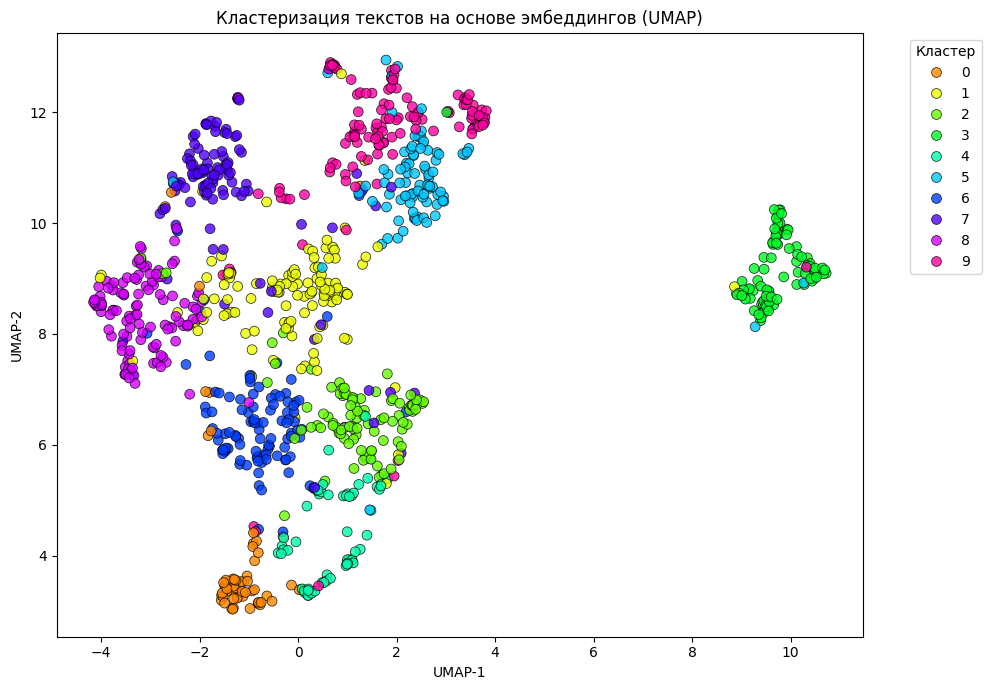

In [26]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# Понижение размерности
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42)
# n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре)
# min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы)
# metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X)

# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y)))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=y, palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [9]:
# Разделение на обучающую и валидационную выборки
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, pseudo_labels, test_size=0.2, random_state=42, stratify=pseudo_labels
)

In [ ]:
# Загрузка модели и токенизатора
model_name = "cointegrated/rubert-tiny2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

In [ ]:
# Проверка на наличие GPU в Colab
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [12]:
# Токенизация данных
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

train_dataset = Dataset.from_dict({"text": train_texts, "label": train_labels})
val_dataset = Dataset.from_dict({"text": val_texts, "label": val_labels})

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
val_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

In [13]:
# Настройка аргументов обучения
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=False,
    report_to="none",
    fp16=True,  # Использование 16-битной точности для ускорения на GPU
    gradient_accumulation_steps=2  # Для больших данных увеличиваем градиентный аккумулятор
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [15]:
# Запуск обучения
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,2.271982
2,2.272500,2.241826
3,2.272500,2.228877


TrainOutput(global_step=75, training_loss=2.2568733723958334, metrics={'train_runtime': 8.2078, 'train_samples_per_second': 292.406, 'train_steps_per_second': 9.138, 'total_flos': 8858279116800.0, 'train_loss': 2.2568733723958334, 'epoch': 3.0})

In [26]:
# Предсказание новых псевдо-меток
def predict_pseudo_labels(texts):
  # tokenizer ожидает список строк, а у нас он имеет тип "pandas.Series"
  # поэтому преобразуй Series в список -> .tolist()
  texts_list = df_subset_loaded['text'].tolist()

  # Настройки
  batch_size = 128
  all_preds = []

  # Обработка батчами
  for i in tqdm(range(0, len(texts_list), batch_size)):
    batch_texts = texts_list[i:i + batch_size]

    # Токенизация батча
    tokenized = tokenizer(
        batch_texts,
        padding=True,
        truncation=True,
        return_tensors="pt",
        max_length=256
    )

    tokenized = {k: v.to(device) for k, v in tokenized.items()}

    # Предсказание
    with torch.no_grad():
        outputs = model(**tokenized)
        predictions = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(predictions.cpu().numpy())
  # Финальный массив псевдо меток
  n_pseudo_labels = np.array(all_preds)

  return n_pseudo_labels

  print("Получено меток:", len(n_pseudo_labels))

In [ ]:
 new_pseudo_labels = predict_pseudo_labels(texts)
 new_pseudo_labels

In [35]:
# Подсчет количества по pseudo_labels
counts_pseudo = pd.Series(pseudo_labels).value_counts().sort_index()
counts_pseudo

,count
cluster,
0,58
1,125
2,97
3,96
4,64
5,91
6,103
7,113
8,125


In [31]:
# Подсчет количества по новым меткам
counts = pd.Series(new_pseudo_labels).value_counts().sort_index()
counts

,count
1,148
3,5
5,8
6,26
7,28
8,332
9,453


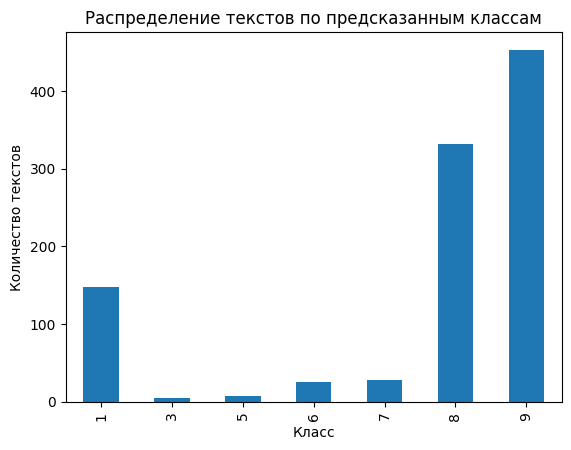

In [32]:
import matplotlib.pyplot as plt

counts.plot(kind='bar')
plt.xlabel("Класс")
plt.ylabel("Количество текстов")
plt.title("Распределение текстов по предсказанным классам")
plt.show()

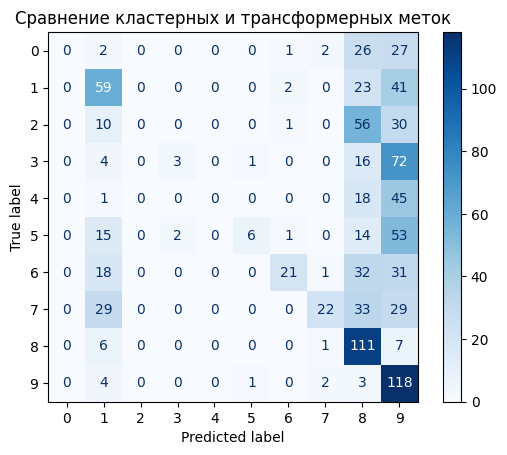

In [34]:
# Матрица ошибок (Confusion Matrix):
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(pseudo_labels, new_pseudo_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Сравнение кластерных и трансформерных меток")
plt.show()

In [36]:
# Метрики согласованности:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

ari = adjusted_rand_score(pseudo_labels, new_pseudo_labels)
ami = adjusted_mutual_info_score(pseudo_labels, new_pseudo_labels)

print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Adjusted Mutual Info (AMI): {ami:.4f}")

Adjusted Rand Index (ARI): 0.0990
Adjusted Mutual Info (AMI): 0.1809


In [29]:
# Добавляем столбец  "cluster" в df_subset
df_subset_loaded = df_subset_loaded.copy()  # Создаем независимую копию
df_subset_loaded["cluster_2"] = list(new_pseudo_labels)  # Теперь можно безопасно изменять
df_subset_loaded.head()

,text,embedding,cluster,cluster_2
0,Военный конфликт в Ливии развивается стремител...,[ 9.36453864e-02 -2.63940971e-02 2.55011357e-...,2,8
1,Политика премьер-министра Великобритании Дэвид...,[ 8.71069077e-03 3.12048644e-02 1.30712045e-...,7,8
2,"«Северный поток-2» - это смерть для Украины, у...",[ 0.02418472 -0.00175609 0.0424107 -0.022844...,8,8
3,Нефть продолжает дорожать. Цена Brent приблизи...,[ 0.02492024 0.00394903 -0.02089648 -0.017880...,8,8
4,"Компания Eviterra заявляет, что проданные ей и...",[ 1.41431419e-02 -7.30392383e-03 -5.42364903e-...,7,9


In [30]:
# Cохранение (текст, эмбеддинги, метки, метки)

# Google Colab
output_file_short = f"/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/clusters_rubert-tiny2_KMeans_fine_{num_object}.csv"

# Локально
# output_file_short = f"./Data/clusters_rubert-tiny2_KMeans_fine_{num_object}.csv"

df_subset_loaded.to_csv(output_file_short, index=False, encoding="utf-8")
print(f"✅ Кластеры сохранены в {output_file_short}.")

✅ Кластеры сохранены в /content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/clusters_rubert-tiny2_KMeans_fine_1000.csv.


## <font color='lightgreen'>_-> Визуализация эмбеддингов и кластеров._</font>

In [2]:
# Связь с файлами на Google drıve
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
output_file_new = "/content/drive/My Drive/Example_ML/classification_text/Classifiers/Data/clusters_rubert-tiny2_KMeans_fine_1000.csv"
df_subset_new = pd.read_csv(output_file_new, encoding="utf-8") # Читаем файл
print(df_subset_new.head(2))

                                                text  \
0  Военный конфликт в Ливии развивается стремител...   
1  Политика премьер-министра Великобритании Дэвид...   

                                           embedding  cluster  cluster_2  
0  [ 9.36453864e-02 -2.63940971e-02  2.55011357e-...        2          8  
1  [ 8.71069077e-03  3.12048644e-02  1.30712045e-...        7          8  


In [10]:
type(df_subset_new["embedding"].iloc[0])

numpy.ndarray

In [27]:
# Количественное распределение текстов по кластерам:
from collections import Counter
counts_cluster = Counter(df_subset_new['cluster_2'])
counts_cluster

Counter({8: 332, 9: 453, 1: 148, 7: 28, 6: 26, 5: 8, 3: 5})

Какова кластеризация после fıne-tunning и классификации моделью `rubert-tiny2`

In [33]:
# Разделяем данные на признаки и метки
# Эмбеддинги
# Преобразуем строки с эмбеддингами в массив чисел
# Преобразуем столбец с эмбеддингами в numpy-массив
X = np.vstack(df_subset_new["embedding"].values)

# Метки
y = df_subset_new['cluster_2']

print(X.shape, X.dtype) # Должно быть (количество образцов, размерность эмбеддинга) Должно быть float32 или float64
print(y.shape, y.dtype) # Должно быть (количество образцов, ) Должно быть int64

(1000, 312) float32
(1000,) int64


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


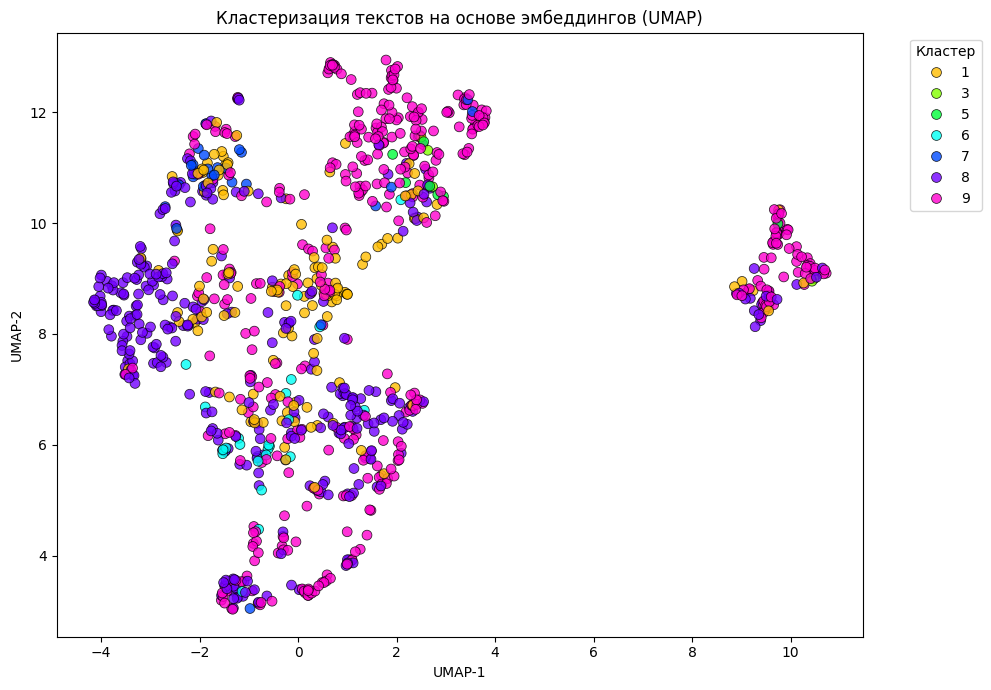

In [34]:
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import pandas as pd

# Понижение размерности
reducer = umap.UMAP(n_neighbors=7, min_dist=0.1, metric='cosine', random_state=42)
# n_neighbors=15	Сколько ближайших соседей учитывать	(влияет на "локальность" — чем меньше, тем сильнее UMAP фокусируется на локальной структуре)
# min_dist=0.1	Минимальная допустимая дистанция между точками (в низкомерном пространстве	чем меньше, тем плотнее группы)
# metric='cosine'	Метрика расстояния	(cosine лучше работает с эмбеддингами, чем euclidean)
embeddings_2d = reducer.fit_transform(X)

# Визуализация
plt.figure(figsize=(10, 7))
palette = sns.color_palette("hsv", len(set(y)))
sns.scatterplot(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], hue=y, palette=palette, s=50, alpha=0.8, edgecolor='k')
plt.title("Кластеризация текстов на основе эмбеддингов (UMAP)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Кластер", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
